### IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### DATA PROCESSING

read the data


In [2]:
df = pd.read_csv("toolwindow_data.csv")
df.head()

,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5


convert timestamps

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.head()

,timestamp,event,open_type,user_id
0,2025-07-11 16:10:04.033,opened,manual,1
1,2025-07-06 21:09:01.616,closed,NaN,2
2,2025-07-12 07:14:35.081,closed,NaN,3
3,2025-07-14 13:15:34.494,opened,auto,4
4,2025-07-10 10:06:31.110,closed,NaN,5


In [4]:
len(df)

3503

sort df by user id and timestamp

In [5]:
df = df.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)
df.head()

,timestamp,event,open_type,user_id
0,2025-07-06 18:21:42.123,opened,auto,1
1,2025-07-06 18:32:26.077,closed,NaN,1
2,2025-07-06 22:34:18.635,opened,manual,1
3,2025-07-07 00:52:24.609,closed,NaN,1
4,2025-07-08 14:38:07.772,opened,manual,1


combine the rows for each open-close pair  
assumptions  
- take the last of the consecutive open events
- take the first of the consecutive close events

In [6]:
df_combined = pd.DataFrame(columns=["open_time", "close_time", "type", "user_id"])

for _, group in df.groupby("user_id"):
    group = group.reset_index(drop=True)
    previous_events = group["event"].shift(1)
    next_events = group["event"].shift(-1)

    for idx, row in group.iterrows():
        prev = previous_events.iloc[idx]
        next = next_events.iloc[idx]

        if row["event"] == "opened" and next == "closed":
            current_open = [row["timestamp"], pd.NaT, row["open_type"], row["user_id"]]
        elif row["event"] == "closed" and prev == "opened":
            current_open[1] = row["timestamp"]
            df_combined.loc[len(df_combined)] = current_open

In [7]:
df_combined.head()

,open_time,close_time,type,user_id
0,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077,auto,1
1,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609,manual,1
2,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885,manual,1
3,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781,manual,1
4,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775,manual,1


In [8]:
len(df_combined)

1622

In [9]:
df_combined.isna().sum()

open_time     0
close_time    0
type          0
user_id       0
dtype: int64

we have no missing values

let's calculate how long this window stays open for each session and add it to the dataframe

In [10]:
df_combined["duration"] = df_combined["close_time"] - df_combined["open_time"]
df_combined.head()

,open_time,close_time,type,user_id,duration
0,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077,auto,1,0 days 00:10:43.954000
1,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609,manual,1,0 days 02:18:05.974000
2,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885,manual,1,0 days 00:18:56.113000
3,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781,manual,1,0 days 00:00:00.748000
4,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775,manual,1,0 days 02:00:27.188000


### EXPLORATORY DATA ANALYSIS

In [11]:
summary = df_combined.groupby('type')['duration'].agg(['mean', 'median', 'min', 'max', 'std'])
print("Summary Statistics by Session Type:")
print(summary)

Summary Statistics by Session Type:
                            mean                 median  \
type                                                      
auto      0 days 01:45:23.446365 0 days 00:03:04.820500   
manual 0 days 00:24:30.259863344 0 days 00:00:12.059000   

                          min                    max                       std  
type                                                                            
auto   0 days 00:00:00.154000 4 days 17:51:13.748000 0 days 07:57:06.912755071  
manual 0 days 00:00:00.015000 2 days 02:15:18.694000 0 days 02:58:45.427369136  


- Mean vs Median

Auto:  
Mean: ~1 hour 45 min  
Median: ~3 min  
Observation: Huge difference => distribution is heavily right-skewed. Most auto opens are very short, but some sessions last days, pulling the mean up.  

Manual:  
Mean: ~24 min  
Median: ~12 sec  
Observation: Extreme skew. Most manual opens are extremely short, but a few long sessions inflate the mean.  

- Min and Max

Auto: 0.15 sec and 4 days 17 hours  
Manual: 0.015 sec and 2 days 2 hours  

- Standard Deviation

Auto: ~7 hours 57 min  
Manual: ~2 hours 58 min  
Observation: High variability => duration distributions are highly spread and skewed.

There is a strong skew in both distributions. The mean is much greater than the median => heavy right skew (many short sessions, a few extremely long ones).

Auto sessions are long, variable, passive. Long max and high standard deviation show that some tool windows stay open for hours or days.
Manual sessions are short and intentional. Median is only 12 seconds. Users likely open and close them for quick checks or actions.

CDF plot

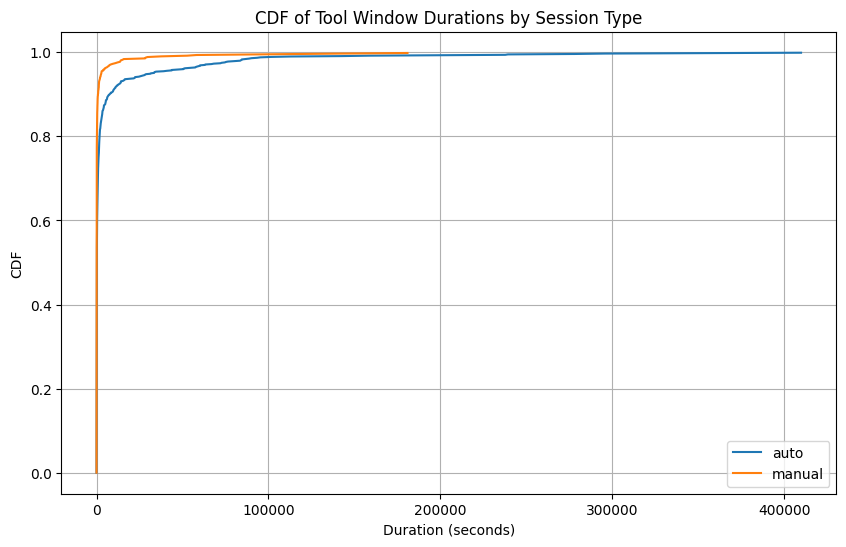

In [12]:
df_combined['duration_sec'] = df_combined['duration'].dt.total_seconds()

plt.figure(figsize=(10,6))
for t in df_combined['type'].unique():
    sorted_durations = np.sort(df_combined[df_combined['type'] == t]['duration_sec'])
    cdf = np.arange(len(sorted_durations)) / len(sorted_durations)
    plt.plot(sorted_durations, cdf, label=t)

plt.title("CDF of Tool Window Durations by Session Type")
plt.xlabel("Duration (seconds)")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()

There is a steeper rise for manual sessions (orange line). Manual sessions reach high CDF values (e.g., 0.9 or 0.95) much faster.  
=> 90–95% of manual windows close quickly, within a relatively short time span.

Auto sessions (blue line) rise more gradually. The blue line lags behind => auto windows stay open longer.  
Even though both eventually reach 1.0, a significant portion of auto sessions have higher durations before closing.

There is a heavy tail for auto durations. The long horizontal stretch of the blue line at the right side (past 100k seconds) indicates a few extremely long auto sessions.

Manual sessions plateau earlier => Suggests deliberate user control. People open and close them intentionally.

Let's identify 95th percentile durations (when CDF = 0.95).

In [13]:
percentiles = (df_combined.groupby('type')['duration'].quantile(0.95).reset_index(name='95th_percentile_duration'))
print(percentiles)

     type  95th_percentile_duration
0    auto 0 days 08:42:55.611499999
1  manual 0 days 00:44:31.599549999


Auto sessions stay open much longer. 95% of auto tool window sessions last up to 8.7 hours, and the top 5% go beyond that. This suggests users rarely close automatically opened windows manually, they stay open passively for long stretches.

Manual sessions are short and deliberate. 95% of manual sessions last less than an hour, showing users typically open these windows only when needed, then close them.

Duration gap is ~10 times. The auto windows persist roughly 10 times longer than manual ones.

Let's do Mann–Whitney U test to verify that auto and manual sessions truly differ.

In [14]:
auto = df_combined.loc[df_combined["type"]=="auto", "duration"]
manual = df_combined.loc[df_combined["type"]=="manual", "duration"]

stat, p = mannwhitneyu(auto, manual, alternative="two-sided")
print(f"P-value: {p}")

P-value: 1.9954601785625834e-63


The null hypothesis is "There is no difference between auto and manual session durations."

The alternative hypothesis is "Auto and manual durations come from different distributions."

Because your p-value << 0.05 (actually near zero), we reject the null hypothesis with overwhelming confidence.

Conclusion: There is a statistically significant difference between auto and manual tool window durations.